# Exploring the image metadata

## Load the dataset

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import geopandas
from scivision.io import load_dataset

In [2]:
cat = load_dataset('https://github.com/alan-turing-institute/plankton-dsg-challenge')

ds_all = cat.plankton_multiple().to_dask()
labels = cat.labels().read()

labels_dedup = xr.Dataset.from_dataframe(
    labels
    .drop_duplicates(subset=["filename"])
    .set_index("filename")
    .sort_index()
)

ds_labelled = (
    ds_all
    .swap_dims({"concat_dim": "filename"})
    .merge(labels_dedup, join="inner")
    .swap_dims({"filename": "concat_dim"})
)

## Extracting EXIF data

We work with a small sample of the data below, since loading the full dataset can take some time.

The EXIF data variables have types from the [ExifRead](https://pypi.org/project/ExifRead/) library.

In [3]:
# initialize random number generator for making the selection 
rng = np.random.default_rng()

In [4]:
ds_subset = ds_labelled.sel(
    concat_dim=rng.choice(ds_labelled.concat_dim, size=2000, replace=False)
)

Read the dataset into memory

In [5]:
ds_subset.load()

<xarray.Dataset>
Dimensions:                               (concat_dim: 2000, y: 832, x: 1040, channel: 3)
Coordinates:
    filename                              (concat_dim) object 'Pia1.2020-10-1...
  * concat_dim                            (concat_dim) int64 38119 ... 22779
  * y                                     (y) int64 0 1 2 3 ... 828 829 830 831
  * x                                     (x) int64 0 1 2 3 ... 1037 1038 1039
  * channel                               (channel) int64 0 1 2
Data variables: (12/27)
    raster                                (concat_dim, y, x, channel) uint8 1...
    EXIF Image ImageWidth                 (concat_dim) object 64 64 64 ... 64 64
    EXIF Image ImageLength                (concat_dim) object 68 88 ... 62 112
    EXIF Image BitsPerSample              (concat_dim) object [8, 8, 8] ... [...
    EXIF Image Compression                (concat_dim) object Uncompressed .....
    EXIF Image PhotometricInterpretation  (concat_dim) object 2 2 2 2 ... 2 2 2
    ...                                    ...
    EXIF GPS GPSLongitude                 (concat_dim) object [4, 90353/2500,...
    EXIF Image GPSInfo                    (concat_dim) object 236 236 ... 236
    index                                 (concat_dim) int64 38167 ... 22827
    label1                                (concat_dim) object 'detritus' ... ...
    label2                                (concat_dim) object 'detritus' ... ...
    label3                                (concat_dim) object 'detritus' ... ...

In [6]:
print(ds_subset)

<xarray.Dataset>
Dimensions:                               (concat_dim: 2000, y: 832, x: 1040, channel: 3)
Coordinates:
    filename                              (concat_dim) object 'Pia1.2020-10-1...
  * concat_dim                            (concat_dim) int64 38119 ... 22779
  * y                                     (y) int64 0 1 2 3 ... 828 829 830 831
  * x                                     (x) int64 0 1 2 3 ... 1037 1038 1039
  * channel                               (channel) int64 0 1 2
Data variables: (12/27)
    raster                                (concat_dim, y, x, channel) uint8 1...
    EXIF Image ImageWidth                 (concat_dim) object 64 64 64 ... 64 64
    EXIF Image ImageLength                (concat_dim) object 68 88 ... 62 112
    EXIF Image BitsPerSample              (concat_dim) object [8, 8, 8] ... [...
    EXIF Image Compression                (concat_dim) object Uncompressed .....
    EXIF Image PhotometricInterpretation  (concat_dim) object 2 2 2 2 ..

Extract the EXIF data of one image, to use as an example in the following sections:

In [7]:
one_image = ds_subset.isel(concat_dim=0)

### DateTime

Extract one EXIF field of one image (`to_numpy()` returns a 0-dimensional numpy array -- extract the value from this as below)

In [8]:
one_datetime = one_image['EXIF Image DateTime'].to_numpy()[()]
one_datetime

(0x0132) ASCII=2020-10-15 01:05:07 @ 318

In [9]:
type(one_datetime)

exifread.classes.IfdTag

In [10]:
one_datetime.values

'2020-10-15 01:05:07'

In [11]:
type(one_datetime.values)

str

Insert an extra data variable with the time as a `datetime`:

In [12]:
ds_subset = ds_subset.assign(
    datetime=pd.to_datetime(
        ds_subset['EXIF Image DateTime']
            .to_pandas()
            .apply(lambda x: x.values)
            # The format used in the timestamp uses ':' and '' inconsistently
            # Replace with something else before we extract the value as a datetime
            .str.replace("[:-]", "_"),
        format="%Y_%m_%d %H_%M_%S"
    )
)

print(ds_subset)

/tmp/ipykernel_10102/2220012349.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  ds_subset['EXIF Image DateTime']


<xarray.Dataset>
Dimensions:                               (concat_dim: 2000, y: 832, x: 1040, channel: 3)
Coordinates:
    filename                              (concat_dim) object 'Pia1.2020-10-1...
  * concat_dim                            (concat_dim) int64 38119 ... 22779
  * y                                     (y) int64 0 1 2 3 ... 828 829 830 831
  * x                                     (x) int64 0 1 2 3 ... 1037 1038 1039
  * channel                               (channel) int64 0 1 2
Data variables: (12/28)
    raster                                (concat_dim, y, x, channel) uint8 1...
    EXIF Image ImageWidth                 (concat_dim) object 64 64 64 ... 64 64
    EXIF Image ImageLength                (concat_dim) object 68 88 ... 62 112
    EXIF Image BitsPerSample              (concat_dim) object [8, 8, 8] ... [...
    EXIF Image Compression                (concat_dim) object Uncompressed .....
    EXIF Image PhotometricInterpretation  (concat_dim) object 2 2 2 2 ..

Histogram of the time of day when each image was taken

<AxesSubplot:xlabel='Hour of the day', ylabel='Frequency density'>

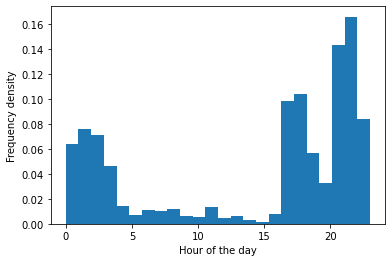

In [13]:
ax = (
    ds_subset.datetime.dt.hour
    .to_pandas()
    .plot.hist(bins=24, density=True)
)
ax.set_xlabel("Hour of the day")
ax.set_ylabel("Frequency density")
ax

### GPS coordinates

The GPS coordinates are stored as a list of rational numbers, '[degrees, minutes, seconds]', in `EXIF GPS GPSLatitude` and `EXIF GPS GPSLongitude`. Longitudes are given as east or west of the prime meridian depending on `EXIF GPS GPSLongitudeRef`, and latitudes are given as north or south of the equator depending on `EXIF GPS GPSLatitudeRef`.

In [14]:
one_latitude = (
    one_image['EXIF GPS GPSLatitude']
    .to_numpy()[()]
    .values
)
one_latitude

[49, 53661/5000, 0]

In [15]:
print(type(one_latitude[0]))

<class 'exifread.utils.Ratio'>


In [16]:
[r.as_integer_ratio() for r in one_latitude]

[(49, 1), (53661, 5000), (0, 1)]

Convert to floating point representation

In [17]:
one_latitude_float = [r.decimal() for r in one_latitude]
one_latitude_float[0] + one_latitude_float[1] / 60.0 + one_latitude_float[2] / 3600.0

49.17887

In [18]:
one_image['EXIF GPS GPSLatitudeRef'].to_numpy()[()].values

'N'

In [19]:
@np.vectorize
def GPS_to_float(v, ref):
    dms = [r.decimal() for r in v.values]
    result_abs = dms[0] + dms[1] / 60.0 + dms[2] / 3600.0
    sign = 1.0 if ref.values == 'E' or ref.values == 'N' else -1.0
    return sign * result_abs

In [20]:
ds_subset = ds_subset.assign(
    latitude=("concat_dim", GPS_to_float(ds_subset['EXIF GPS GPSLatitude'], ds_subset['EXIF GPS GPSLatitudeRef'])),
    longitude=("concat_dim", GPS_to_float(ds_subset['EXIF GPS GPSLongitude'], ds_subset['EXIF GPS GPSLongitudeRef'])),
)

#### Visualize the locations and labels with GeoPandas

In [21]:
geo_data = (
    ds_subset[['latitude', 'longitude', 'label3']]
    .to_pandas()
    .drop(columns=['filename'])
)

df_geo = geopandas.GeoDataFrame(
    geo_data.drop(columns=['latitude', 'longitude']),
    # Note argument order to points_from_xy!
    geometry=geopandas.points_from_xy(geo_data.longitude, geo_data.latitude)
)

df_geo['label3'] = df_geo['label3'].astype('category')
df_geo

,label3,geometry
concat_dim,,
38119,detritus,POINT (-4.60235 49.17887)
54085,detritus,POINT (-5.25707 49.00303)
45168,detritus,POINT (-4.99551 48.55421)
4565,mysideacea,POINT (-3.76014 51.35949)
4552,mysideacea,POINT (-3.75893 51.35848)
...,...,...
18375,nt_phyto_chains,POINT (-2.89637 50.58385)
40588,detritus,POINT (-4.85641 49.67322)
53499,detritus,POINT (-5.26091 48.99721)


In [22]:
# load geopandas' built-in world geometry
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

Next, plot the GPS coordinates of the sample.

Note the cluster of points at (0.0, 0.0).

<AxesSubplot:>

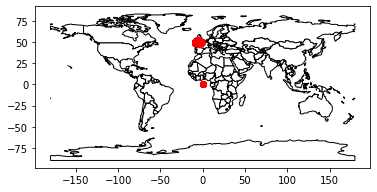

In [23]:
ax = world.plot(color='white', edgecolor='black')
df_geo.plot(ax=ax, color='red')

<AxesSubplot:>

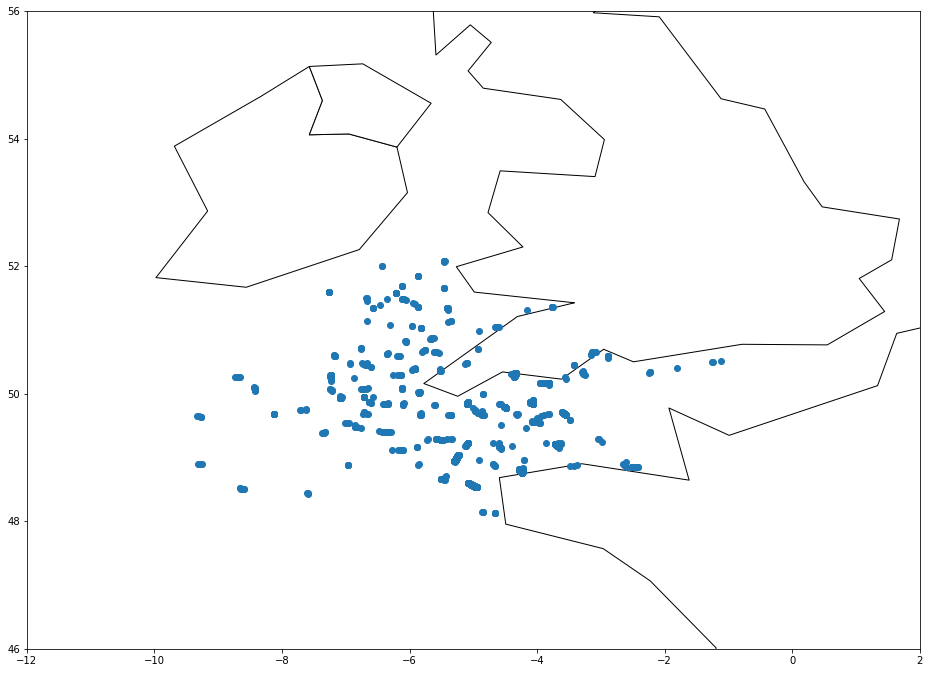

In [24]:
fig = plt.figure(figsize=(16.0, 16.0))
ax = plt.axes()
ax.set_xlim((-12.0, 2.0))
ax.set_ylim((46.0, 56.0))
world.plot(ax=ax, color='white', edgecolor='black')
df_geo.plot(ax=ax)

In [25]:
df_geo.explore('label3', control_scale=False)